In [ ]:
cd '/mmfs1/data/aglinska/BC-MRI-AE/Colab Notebooks/'

In [2]:
import pickle

import numpy as np
import pandas as pd 

from importlib import reload

import helper_funcs;reload(helper_funcs);from helper_funcs import *
import make_models;reload(make_models);from make_models import *

from functools import partial
from sklearn.decomposition import PCA
import scipy
from matplotlib import pyplot as plt
from sklearn.mixture import BayesianGaussianMixture as bnpc

import shutil
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [3]:
%%time 
import ants

CPU times: user 1.19 s, sys: 524 ms, total: 1.72 s
Wall time: 5.34 s


In [4]:
# LOAD ABIDE DATA
dataFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE-Anat-64iso-S982.npz'
dfFnOut = '/mmfs1/data/aglinska/BC-MRI-AE/Data/ABIDE_legend_S982.csv'

ABIDE_data = np.load(dataFnOut)['data']
df = pd.read_csv(dfFnOut)

patients = df['DxGroup'].values==1
controls = df['DxGroup'].values==2
abide_asd = ABIDE_data[patients,:,:,:]

In [5]:
# LOAD SFARI 
arr = np.load('../Data/SFARI-Anat-64iso-S121.npz')
dfs = pd.read_csv('../Data/sfari_legend_S121.csv')

SFARI_data = arr['data']
SFARI_subs = arr['subs']

sfari_subs_td = dfs['family_type'].values=='non-familial-control'
sfari_subs_dupl = dfs['family_type'].values=='16p-duplication'
sfari_subs_del = dfs['family_type'].values=='16p-deletion'

In [6]:
# LOAD VAE
latent_dim=32;batch_size=64;disentangle=False;gamma=1
encoder, decoder, vae = get_MRI_VAE_3D(input_shape=(64, 64, 64, 1), latent_dim=latent_dim, batch_size=batch_size, disentangle=disentangle, gamma=gamma)
fn = '/mmfs1/data/aglinska/tf_outputs/VAE/Jan12th_16d'

loss = list()
print('ready')
if os.path.exists(fn+'_loss.pickle'):
    print('loading')
    vae.load_weights(fn)
    loss = pickle.load(open(fn+'_loss.pickle','rb'))

ready
loading


In [7]:
# LOAD CVAE
latent_dim = 16;batch_size = 32;beta = 1;gamma = 100;disentangle = True
cvae, z_encoder, s_encoder, cvae_decoder = get_MRI_CCVAE_3D(latent_dim=latent_dim,beta=beta, disentangle=disentangle, gamma=gamma, bias=True, batch_size = batch_size)

fn = '/mmfs1/data/aglinska/tf_outputs/CVAE/Feb23_1551_D16B1G100_DTrue'
loss = pickle.load(open(fn+'_loss.pickle','rb'))
cvae.load_weights(fn)

470


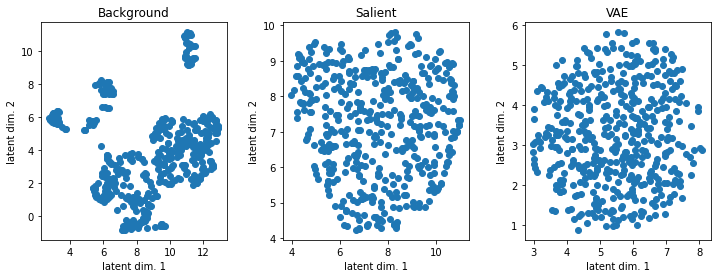

In [8]:
# PLOT
w = 2
vae_space = dim_reduce(encoder.predict(ABIDE_data)[w])
bg_space,sl_space = get_spaces(ABIDE_data, z_encoder, s_encoder, w=w, method='UMAP')

fig = cscatter([bg_space,sl_space,vae_space],v=patients,return_axes=True)

In [9]:
def inverse_tx_umap(targ,s_embedding):
    targ = np.array(targ)
    idx = np.argsort(((s_embedding-targ)**2).sum(axis=1))
    return idx

def get_umap_corners(s_embedding):
    ax_min = s_embedding.min(axis=0)
    ax_max = s_embedding.max(axis=0)
    ll = inverse_tx_umap((ax_min[0],ax_min[1]),s_embedding)
    lr = inverse_tx_umap((ax_max[0],ax_min[1]),s_embedding)
    tl = inverse_tx_umap((ax_min[0],ax_max[1]),s_embedding)
    tr = inverse_tx_umap((ax_max[0],ax_max[1]),s_embedding)
    cntr = inverse_tx_umap(s_embedding.mean(axis=0),s_embedding)
    
    map_ = dict()
    map_['ll'] = ll
    map_['lr'] = lr
    map_['tr'] = tr
    map_['tl'] = tl
    map_['center'] = cntr

    return map_

def get_brain_pair(b_vec,s_vec):
    
    vec_asd = np.hstack((b_vec,s_vec))
    vec_td = np.hstack((b_vec,np.zeros(16)))

    im_asd = cvae_decoder.predict(np.vstack((vec_asd,vec_asd)))[0,:,:,:,0]
    im_td = cvae_decoder.predict(np.vstack((vec_td,vec_td)))[0,:,:,:,0]
    
    thresh = 0.0
    im_asd[im_asd<thresh]=0
    im_td[im_td<thresh]=0
    
    nii_asd = template.new_image_like(im_asd)
    nii_td = template.new_image_like(im_td)
    
    nii_asd.set_origin(tuple(np.array(nii_asd.origin)-np.array(nii_asd.get_center_of_mass())))
    nii_td.set_origin(tuple(np.array(nii_asd.origin)-np.array(nii_asd.get_center_of_mass())))
    
    return nii_td,nii_asd

def clean_tx_folder(tx):
    [os.remove(f) for f in np.unique(np.vstack((np.array(tx['fwdtransforms']),np.array(tx['invtransforms']))))];

(470, 2)


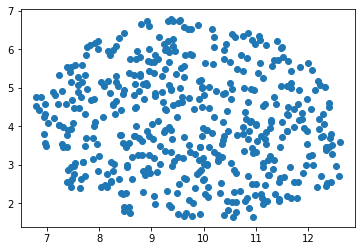

In [50]:
w = 2

data = ABIDE_data[patients,:,:,:]
space_sl = s_encoder.predict(data)[w]
space_bg = z_encoder.predict(data)[w]

reducer = umap.UMAP(n_components=2)
s_embedding = reducer.fit_transform(space_sl)
plt.scatter(s_embedding[:,0],s_embedding[:,1])
print(s_embedding.shape)
map_ = get_umap_corners(s_embedding)

In [11]:
template = ants.image_read('/mmfs1/data/aglinska/BC-ASD-FC/Atlas/Atlas_brain_2mm.nii')
template = ants.resample_image(template,(64,64,64),use_voxels=True,interp_type=4)

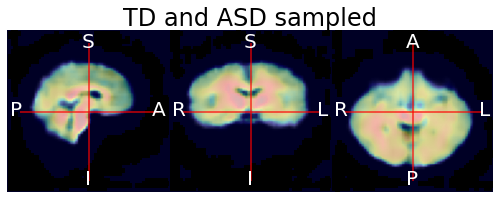

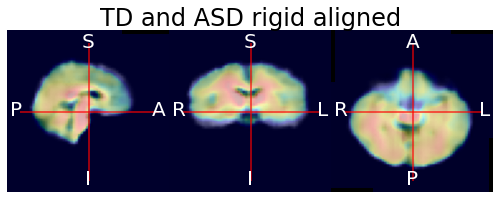

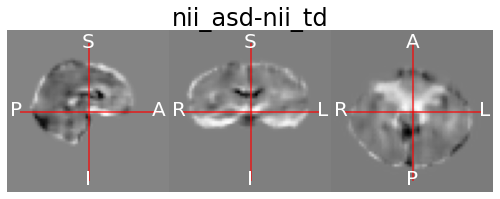

In [158]:
idx = map_['ll'][3]

do_plot = True;normalize=False

nii_td,nii_asd = get_brain_pair(space_bg[idx,:],space_sl[idx,:])

if do_plot:
    nii_asd.plot_ortho((nii_td),overlay_alpha=.3,flat=True,title='TD and ASD sampled')

outdir = '/data/aglinska/txs/'

tx = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='Rigid',outprefix=outdir)
nii_td = ants.apply_transforms(fixed=nii_asd,moving=nii_td,transformlist=tx['fwdtransforms'],interpolator='bSpline')


#clean_tx_folder(tx)

if do_plot:
    nii_asd.plot_ortho((nii_td),overlay_alpha=.3,flat=True,title='TD and ASD rigid aligned')

if normalize:
    
    templateTiny = template.resample_image((64,64,64), use_voxels=True, interp_type=4)
    templateTiny.set_origin(tuple(np.array(templateTiny.origin)-np.array(templateTiny.get_center_of_mass())))

    if do_plot:
        templateTiny.plot_ortho(overlay=nii_asd,overlay_alpha=.3,flat=True,title='template overlay asd')

    txR2T = ants.registration(fixed=templateTiny,moving=nii_td,type_of_transform='Rigid',outprefix=outdir)
    nii_td = ants.apply_transforms(fixed=templateTiny,moving=nii_td,transformlist=txR2T['fwdtransforms'],interpolator='bSpline')
    nii_asd = ants.apply_transforms(fixed=templateTiny,moving=nii_asd,transformlist=txR2T['fwdtransforms'],interpolator='bSpline')

    if do_plot:
        templateTiny.plot_ortho(overlay=nii_td,overlay_alpha=.3,flat=True,title='template overlay ASD rigid')

    txNorm = ants.registration(fixed=templateTiny,moving=nii_asd,type_of_transform='SyN',outprefix=outdir)
    nii_td = ants.apply_transforms(fixed=templateTiny,moving=nii_td,transformlist=txNorm['fwdtransforms'],interpolator='bSpline')
    nii_asd = ants.apply_transforms(fixed=templateTiny,moving=nii_asd,transformlist=txNorm['fwdtransforms'],interpolator='bSpline')

    if do_plot:
        templateTiny.plot_ortho((nii_asd),overlay_alpha=.3,flat=True,title='template overlay ASD SyN')


# WARP TD INTO ASD
txT2A = ants.registration(fixed=nii_asd,moving=nii_td,type_of_transform='SyN',outprefix=outdir)

# WANT JACOBIANS?
J = ants.create_jacobian_determinant_image(nii_td,txT2A['fwdtransforms'][0])
J1 = ants.create_jacobian_determinant_image(nii_td,txT2A['invtransforms'][1])

# LOAD WARP as an image
nii_tx = ants.image_read(txT2A['fwdtransforms'][0])

if do_plot:
    (nii_asd-nii_td).plot_ortho(title='nii_asd-nii_td',flat=True)
    
nii_td.to_filename('/mmfs1/data/aglinska/ims/nii_td.nii')
nii_asd.to_filename('/mmfs1/data/aglinska/ims/nii_asd.nii')
nii_tx.to_filename('/mmfs1/data/aglinska/ims/nii_tx.nii')

In [75]:
def f(x,y,z):
    ''' return transformed coordinates'''
    i,j,k = np.array([x,y,z])+nii_tx.numpy()[x,y,z,:]
    return i,j,k

In [57]:
def get_C(x,y,z):
    J = np.zeros((3,3))
    J[:,0] = np.array(f(x,y,z))-np.array(f(x+1,y,z))
    J[:,1] = np.array(f(x,y,z))-np.array(f(x,y+1,z))
    J[:,2] = np.array(f(x,y,z))-np.array(f(x,y,z+1))
    
    C = np.matmul(J.transpose(),J)-np.eye(3)
    return C

In [130]:
mat = np.zeros((64,64,64))
xs,ys,zs = np.nonzero(nii_asd.get_mask().numpy()==1)

for i in tqdm(range(len(xs))):
    mat[xs[i],ys[i],zs[i]] = np.linalg.norm(get_C(xs[i],ys[i],zs[i]))

100%|██████████| 44861/44861 [01:09<00:00, 648.94it/s]


In [131]:
# mat = np.zeros((64,64,64,3,3))
# xs,ys,zs = np.nonzero(nii_asd.get_mask().numpy()==1)
# for i in tqdm(range(len(xs))):
#     mat[xs[i],ys[i],zs[i],:,:] = get_C(xs[i],ys[i],zs[i])

In [132]:
green = nii_asd.new_image_like(mat)
nii_tx.to_filename('/mmfs1/data/aglinska/ims/green.nii')
greenT = green.copy()
greenT[greenT<1.5]=0

In [122]:
J1[abs(J1.numpy()-1)<.1]=0

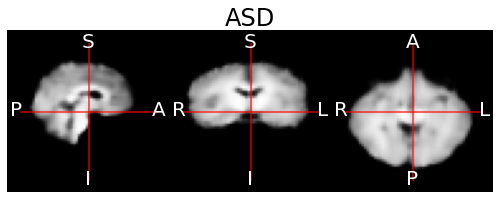

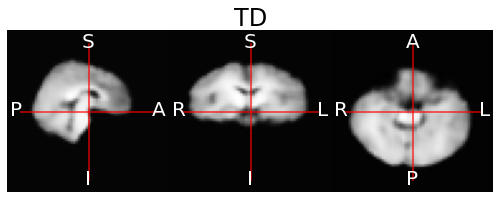

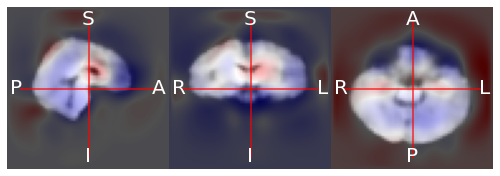

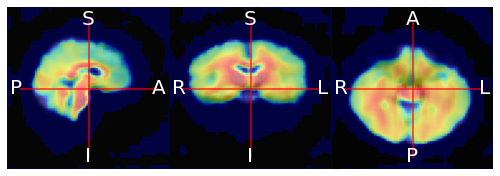

In [159]:
if normalize:
    #templateTiny.plot_ortho(greenT,overlay_alpha=.5,flat=True)
    #templateTiny.plot_ortho(J,overlay_alpha=.5,flat=True)
    #templateTiny.plot_ortho(J1,overlay_alpha=.5,flat=True)
    nii_asd.plot_ortho(flat=True,title='ASD')
    nii_td.plot_ortho(flat=True,title='TD')
    nii_td.plot_ortho(J1,overlay_alpha=.3,flat=True,overlay_cmap='bwr')
    nii_td.plot_ortho(nii_asd,flat=True,overlay_alpha=.5)
else:
    nii_asd.plot_ortho(flat=True,title='ASD')
    nii_td.plot_ortho(flat=True,title='TD')
    nii_td.plot_ortho(J1,overlay_alpha=.3,flat=True,overlay_cmap='bwr')
    nii_td.plot_ortho(nii_asd,flat=True,overlay_alpha=.5)

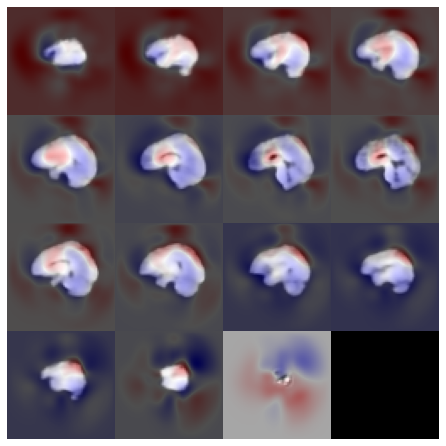

In [160]:
nii_td.plot(J1,overlay_alpha=.3,overlay_cmap='bwr',nslices=15,axis=0)

(array([7.67000e+02, 8.51700e+03, 3.10210e+04, 1.32399e+05, 7.59000e+04,
        9.40900e+03, 2.76200e+03, 1.00500e+03, 2.93000e+02, 7.10000e+01]),
 array([0.5783301 , 0.6902063 , 0.8020825 , 0.91395867, 1.0258348 ,
        1.137711  , 1.2495872 , 1.3614634 , 1.4733396 , 1.5852158 ,
        1.6970919 ], dtype=float32),
 <BarContainer object of 10 artists>)

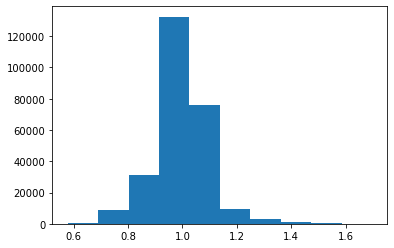

In [111]:
plt.hist(J1.numpy().flatten())